In [1]:
import os, torch, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer
from transformers import AutoImageProcessor, AutoModel
import torchvision.transforms as transforms

# --- CONFIGURATION ---
CFG = {
    "base_path": Path("/kaggle/input/csiro-biomass"),
    "model_path": "/kaggle/input/dinov2/pytorch/large/1",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "n_splits": 5,
    "seed": 42
}

TARGETS = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
# Official competition weights: Dry_Total_g (0.5), GDM_g (0.2), Others (0.1)
COMP_WEIGHTS = np.array([0.1, 0.1, 0.1, 0.2, 0.5]) 
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

2026-01-10 12:47:39.035482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768049259.218180      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768049259.268875      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768049259.692194      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768049259.692239      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768049259.692242      55 computation_placer.cc:177] computation placer alr

In [2]:
def weighted_r2_metric(y_true, y_pred):
    """Calculates Global Weighted R2 based on competition rules."""
    ss_res = np.sum(COMP_WEIGHTS * np.sum((y_true - y_pred)**2, axis=0))
    global_mean = np.average(np.mean(y_true, axis=0), weights=COMP_WEIGHTS)
    ss_tot = np.sum(COMP_WEIGHTS * np.sum((y_true - global_mean)**2, axis=0))
    return 1 - (ss_res / ss_tot)

weighted_scorer = make_scorer(weighted_r2_metric, greater_is_better=True)

def extract_dense_features(df, model):
    """Extracts patch-based embeddings from DINOv2 (Dense Methodology)."""
    tta_transforms = [
        transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize(MEAN, STD)]),
        transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize(MEAN, STD)])
    ]
    unique_paths = df['image_path'].unique()
    all_feats = []
    
    with torch.no_grad():
        for path in tqdm(unique_paths, desc="GPU Feature Extraction"):
            img = Image.open(CFG["base_path"] / path).convert("RGB")
            # Average patch features (ignoring CLS token at index 0)
            tta_results = [model(aug(img).unsqueeze(0).to(CFG["device"])).last_hidden_state[:, 1:, :].mean(dim=1).cpu().numpy() for aug in tta_transforms]
            all_feats.append(np.mean(tta_results, axis=0))
            
    return np.vstack(all_feats), unique_paths

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():
GPU Feature Extraction: 100%|██████████| 357/357 [01:13<00:00,  4.84it/s]



Evaluating LightGBM...
 Fold 1 Weighted R2: 0.5807
 Fold 2 Weighted R2: 0.6072
 Fold 3 Weighted R2: 0.7106
 Fold 4 Weighted R2: 0.6237
 Fold 5 Weighted R2: 0.5682
Average LightGBM Weighted R2: 0.6181 (+/- 0.0502)

Evaluating XGBoost...
 Fold 1 Weighted R2: 0.5319
 Fold 2 Weighted R2: 0.5610
 Fold 3 Weighted R2: 0.6550
 Fold 4 Weighted R2: 0.5169
 Fold 5 Weighted R2: 0.5046
Average XGBoost Weighted R2: 0.5539 (+/- 0.0539)

Evaluating CatBoost...
 Fold 1 Weighted R2: 0.6191
 Fold 2 Weighted R2: 0.6285
 Fold 3 Weighted R2: 0.6873
 Fold 4 Weighted R2: 0.6492
 Fold 5 Weighted R2: 0.5604
Average CatBoost Weighted R2: 0.6289 (+/- 0.0415)

Chart saved to model_comparison.png

Final Inference using CatBoost


/tmp/ipykernel_55/1591067300.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Avg_R2", data=res_df, palette="viridis")
GPU Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Submission saved to submission.csv


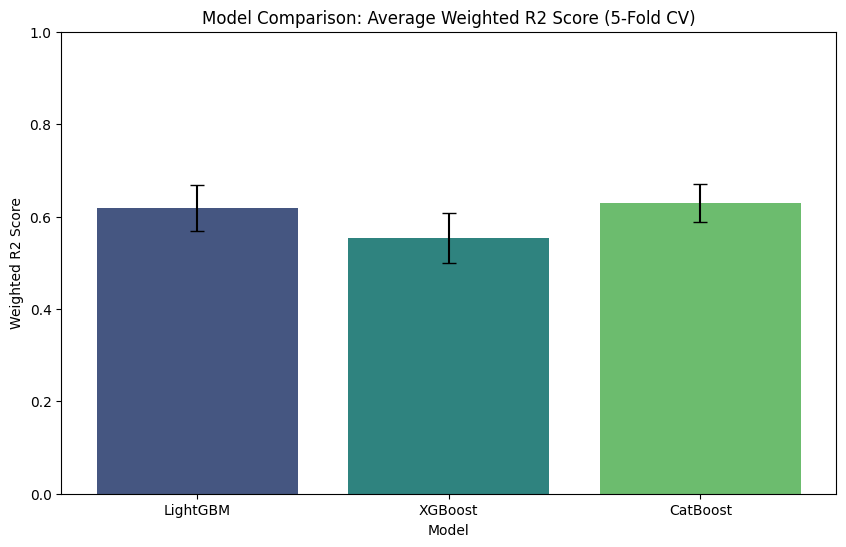

In [3]:
import os, torch, numpy as np, pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from transformers import AutoModel
import torchvision.transforms as transforms

# --- SILENCE WARNINGS ---
warnings.filterwarnings("ignore", category=SyntaxWarning)
warnings.filterwarnings("ignore", category=UserWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# --- CONFIGURATION ---
CFG = {
    "base_path": Path("/kaggle/input/csiro-biomass"),
    "model_path": "/kaggle/input/dinov2/pytorch/large/1",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "n_splits": 5,
    "seed": 42
}

TARGETS = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
COMP_WEIGHTS = np.array([0.1, 0.1, 0.1, 0.2, 0.5]) 
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# --- 1. METRICS ---
def weighted_r2_metric(y_true, y_pred):
    # Calculate R2 for each target
    r2_scores = []
    for i in range(y_true.shape[1]):
        r2_scores.append(r2_score(y_true[:, i], y_pred[:, i]))
    # Apply competition weights
    return np.sum(np.array(r2_scores) * COMP_WEIGHTS)

# --- 2. FEATURE EXTRACTION ---
def extract_dense_features(df, model):
    tta_transforms = [
        transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize(MEAN, STD)]),
        transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize(MEAN, STD)])
    ]
    unique_paths = df['image_path'].unique()
    all_feats = []
    with torch.no_grad():
        for path in tqdm(unique_paths, desc="GPU Feature Extraction"):
            img = Image.open(CFG["base_path"] / path).convert("RGB")
            tta_results = [model(aug(img).unsqueeze(0).to(CFG["device"])).last_hidden_state[:, 1:, :].mean(dim=1).cpu().numpy() for aug in tta_transforms]
            all_feats.append(np.mean(tta_results, axis=0))
    
    feat_matrix = np.vstack(all_feats)
    feat_cols = [f"feat_{i}" for i in range(feat_matrix.shape[1])]
    return pd.DataFrame(feat_matrix, columns=feat_cols), unique_paths

# --- 3. PIPELINE ---
def run_pipeline():
    model_dir = os.path.abspath(CFG["model_path"])
    model = AutoModel.from_pretrained(model_dir, local_files_only=True, trust_remote_code=True).to(CFG["device"]).eval()
    
    # Data Preparation
    train_df = pd.read_csv(CFG["base_path"] / "train.csv")
    train_p = train_df.pivot_table(index="image_path", columns="target_name", values="target").reset_index()
    X_train_df, _ = extract_dense_features(train_p, model)
    Y_train_log = np.log1p(train_p[TARGETS].values)

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X_train_df.columns)

    # Model Definitions
    models_to_test = {
        "LightGBM": MultiOutputRegressor(LGBMRegressor(n_estimators=200, learning_rate=0.05, verbosity=-1, random_state=CFG["seed"])),
        "XGBoost": MultiOutputRegressor(XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=CFG["seed"])),
        "CatBoost": MultiOutputRegressor(CatBoostRegressor(n_estimators=200, learning_rate=0.05, verbose=0, random_state=CFG["seed"]))
    }

    cv_results = []
    kf = KFold(n_splits=CFG["n_splits"], shuffle=True, random_state=CFG["seed"])

    # --- CROSS VALIDATION LOOP ---
    for name, regressor in models_to_test.items():
        print(f"\nEvaluating {name}...")
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled, Y_train_log)):
            X_tr, X_vl = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
            y_tr, y_vl = Y_train_log[train_idx], Y_train_log[val_idx]
            
            regressor.fit(X_tr, y_tr)
            preds = regressor.predict(X_vl)
            
            # Use competition weighted R2 metric
            score = weighted_r2_metric(y_vl, preds)
            fold_scores.append(score)
            print(f" Fold {fold+1} Weighted R2: {score:.4f}")
            
        avg_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        cv_results.append({"Model": name, "Avg_R2": avg_score, "Std_R2": std_score})
        print(f"Average {name} Weighted R2: {avg_score:.4f} (+/- {std_score:.4f})")

    # --- RESULTS VISUALIZATION ---
    res_df = pd.DataFrame(cv_results)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Model", y="Avg_R2", data=res_df, palette="viridis")
    plt.errorbar(x=res_df["Model"], y=res_df["Avg_R2"], yerr=res_df["Std_R2"], fmt='none', c='black', capsize=5)
    plt.title("Model Comparison: Average Weighted R2 Score (5-Fold CV)")
    plt.ylabel("Weighted R2 Score")
    plt.ylim(0, 1.0)
    plt.savefig("model_comparison.png")
    print("\nChart saved to model_comparison.png")

    # --- FINAL PREDICTIONS (Using best model) ---
    best_model_name = res_df.loc[res_df["Avg_R2"].idxmax(), "Model"]
    print(f"\nFinal Inference using {best_model_name}")
    
    final_regressor = models_to_test[best_model_name]
    final_regressor.fit(X_train_scaled, Y_train_log)

    test_df = pd.read_csv(CFG["base_path"] / "test.csv")
    test_uniq = pd.DataFrame({'image_path': test_df['image_path'].unique()})
    X_test_df, test_ids = extract_dense_features(test_uniq, model)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns=X_test_df.columns)

    test_preds_log = final_regressor.predict(X_test_scaled)
    avg_preds = np.maximum(np.expm1(test_preds_log), 0)

    # Submission
    final_rows = []
    for i, path in enumerate(test_ids):
        image_id = Path(path).stem
        for j, target_name in enumerate(TARGETS):
            final_rows.append({"sample_id": f"{image_id}__{target_name}", "target": avg_preds[i, j]})
            
    pd.DataFrame(final_rows).to_csv("submission.csv", index=False)
    print("Submission saved to submission.csv")

if __name__ == "__main__":
    run_pipeline()